# Convolutional Neural Networks (CNN) and Deep Architectures


# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

/home/cindy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import numpy as np
import sys
from matplotlib.pyplot import imshow
import gzip
import _pickle as cPickle


# Preliminary questions

In [4]:
x = tf.placeholder(tf.float32,shape=[])
y = tf.placeholder(tf.float32,shape=[])
f = x*x + 2*y
some_x = [1,2,3]
some_y = [2,3,4]
with tf.Session() as sess:
    for i in range(len(some_x)):
        print(sess.run(f,feed_dict={x: some_x[i],y: some_y[i]}))

5.0
10.0
17.0


### Q1
* Define in a symbolic way the gradient of function $f$ (see `TensorFlow.gradients` documentation) and compute the gradient vectors for the same $(x,y)$ pairs as in the above code. 


In [5]:
gradf_x_y = tf.gradients(ys= x*x+2*y, xs = [x,y])

with tf.Session() as sess:
    for i in range(len(some_x)):
        print(sess.run(gradf_x_y, feed_dict={x:some_x[i],y:some_y[i]}))


[2.0, 2.0]
[4.0, 2.0]
[6.0, 2.0]


In [6]:
a = tf.constant(0.)
b = 2 * a
g = tf.gradients(a + b, [a, b], stop_gradients=[a, b])
g[0]

<tf.Tensor 'gradients_1/Fill:0' shape=() dtype=float32>

# CNN 

---

## Baseline CNN



## Load data

In [4]:
# Load data
def load_mnist(filename):
    f = gzip.open(filename, 'rb')
    train_set, valid_set, test_set = cPickle.load(f, encoding='iso-8859-1')
    f.close()
    X = np.vstack((train_set[0],valid_set[0]))
    y = np.hstack((train_set[1],valid_set[1]))
    X_test = test_set[0]
    y_test = test_set[1]
    return X,y,X_test,y_test

# MISSING CODE
X,y,X_test,y_test = load_mnist( 'mnist.pkl.gz')
#
N_train = X.shape[0]
N_test = X_test.shape[0]

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


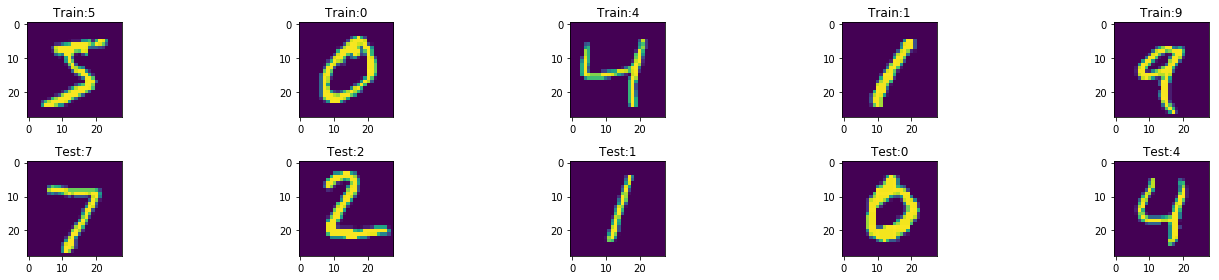

In [5]:
#show some images
plt.subplots(figsize = (20,4))
n_ex = 5
for i in range (n_ex):
    plt.subplot(2,n_ex,i+1)
    plt.imshow(X[i].reshape((28,28,)))
    plt.title("Train:"+str(y[i]))
    
    plt.subplot(2,n_ex,n_ex+i+1)
    plt.imshow(X_test[i].reshape((28,28,)))
    plt.title("Test:"+str(y_test[i]))
plt.tight_layout()

### Q2
* Reshape `X` and `X_test` so that they have shape (60000,28,28,1) and (10000,28,28,1) respectively.


In [6]:
#MISSING CODE

X = X.reshape((N_train,28,28,1))
X_test = X_test.reshape(N_test,28,28,1)


In [ ]:
print("Data already normalized: ",np.max(X), np.mean(X))

We can now begin to build the CNN. At the start of the `TensorFlow` graph we need to define data containers, i.e. instances of `tf.placeholder`. We will use mini-batch gradient descent to optimize the NN parameters and we want the code to be modular so we cannot specify the first dimension of the tensor containing training examples. `TensorFlow` allows this :

In [234]:
tf.reset_default_graph()
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
ytf = tf.placeholder(tf.int64,shape=[None, ])

The next element of our NN is a 2D convolutional layer. We can use an instance of the `tf.layers.conv2d` class. We need to specify that a `tf.placeholder` instance is the input, the number of size of filters (kernels) that we want, how to deal with image borders (padding) and what activation we would like. This gives:

In [235]:
# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

Next, we need a pooling layer to give up some entries of the filtered images provided by the convolutional layer. We will use the usual max pool function in 2x2 neighborhoods which drops 3 entries out of 4 in each such neighborhood. The remaining entry is the one achieving maximal value in the neighborhood.

In [236]:
# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)


## Q3
* What is the role of parameter `strides` ? 
* What is the size of each feature map after max pooling ?
* How many feature maps are there ?

We will now plug a 1 layer MLP on top of this. Fully connected layers (or dense layers) do not accept `numpy ndarrays`. We can use `tf.reshape` to flatten feature maps. In the following code the scalar `dflat` = nbr of feature maps x feature map width x feature map height. Set this variable with the correct value and execute the following code line: 

- stride : is the number of step we take to slide the filter
- The output of the conv2d layer is size (28,28), as the padding is "same" and the stride is 1. After maxpooling of stride 2, we divide the number of pixels by 4. So the size of each feature map after max pooling is (14,14)
- There are 64 filters so 64 feature maps.

In [237]:
dflat = 64*14*14# MISSING CODE
pool2_flat = tf.reshape(pool1, [-1, dflat])
#pool2_flat = tf.layers.Flatten()(pool1)

Now the one layer MLP is given by an instance of `tf.layers.dense` as:

In [238]:
mlp = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)


Finally, we need a softmax regression function to obtain class membership probabilities. This can be done in this way:

In [239]:
logits = tf.layers.dense(inputs=mlp, units=10)
smax = tf.nn.softmax(logits)

### Q4
* How many parameters is there in our NN ?

Actually, the utimate element of the `TensorFlow` graph is the loss. In softmax (or logistic) regression, the corresponding loss is the cross entropy. A numerically stable version of this loss is given by `tf.losses.sparse_softmax_cross_entropy`:

Number of parameters: 
- Conv: 64 filters. Each filter is size 5x5. Each filter has a bias => parameters of filters = 64(5*5+1)
- 1st dense layer: has for input a vector of size dflat. units = 1024, adding the bias we obtain => dflat*1024+1024
- 2nd dense layer: 1024*10+10

In [240]:
number_of_parameters = 64*(5*5+1) + dflat*1024+1024 + 1024*10+10
print("Number of parameters:",number_of_parameters)

Number of parameters: 12857994


In [241]:
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits)

Now that we have completed the graph, we can move to the next phase: actually training the NN. Prior to entering the training loop, we need to instantiate an optimizer from `TensorFlow` and ask him to minimize the loss. We will use the ADAM optimizer which is robust and easy to tune.

In [247]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [248]:
pred = tf.argmax(logits,1)
equal = tf.equal(pred,ytf)
accuracy = tf.reduce_mean(tf.cast(equal,tf.float32))

### Q5
* Fulfill correctly the missing parts of these instructions.
**Warning** : the execution of the loop takes around 5mn. The gradient descent should achieve approximately a 0.13 loss or below (remember this is stochastic).

In [250]:
n_epochs = 5
batch_size = 150
loss_history=[]
saver = tf.train.Saver()

X = X
X_test = X_test
y=y

N_train = X.shape[0]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = N_train // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            y_batch = y[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            
            #Update parameters by computing gradient of loss
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
            loss_history.append(loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch}))
        
        #Compute loss
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        print("\n Accuracy test:", sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test}))
        print("\r{}".format(epoch), "Train loss:", loss_train)

    saver.save(sess, '/home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model')

    


83%
 Accuracy test: 0.3932
0 Train loss: 1.9836406
83%
 Accuracy test: 0.855
1 Train loss: 0.38862655
83%
 Accuracy test: 0.888
2 Train loss: 0.22165598
83%
 Accuracy test: 0.9147
3 Train loss: 0.0768265
83%
 Accuracy test: 0.9108
4 Train loss: 0.01921576


In [251]:
with tf.Session() as sess:
    saver.restore(sess,'/home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model')
    print("\n Accuracy test:", sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test}))

INFO:tensorflow:Restoring parameters from /home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model

 Accuracy test: 0.9108


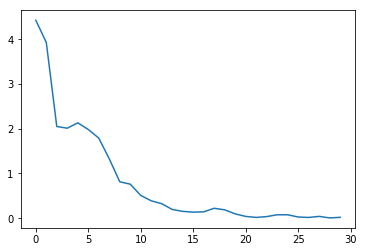

In [252]:
nb_history = len(loss_history)
plt.plot(np.arange(nb_history),loss_history)

Accuracy on test set is 91%, just after 5 epochs, this is quite performant, but not perfect yet, for a simple dataset.

## Q7 Add a second pair of conv/pool layers.
* A smaller amount of filters and smaller filters are recommended.

In [264]:
tf.reset_default_graph()
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
ytf = tf.placeholder(tf.int64,shape=[None, ])


# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)


# Convolutional Layer #2
conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[3,3],
      padding="same",
      activation=tf.nn.relu)

# Pooling Layer #2
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

pool2_flat = tf.layers.Flatten()(pool2)

mlp = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)


logits = tf.layers.dense(inputs=mlp, units=10)
smax = tf.nn.softmax(logits)

In [265]:
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits)

In [266]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [267]:
pred = tf.argmax(logits,1)
equal = tf.equal(pred,ytf)
accuracy = tf.reduce_mean(tf.cast(equal,tf.float32))

In [268]:
n_epochs = 5
batch_size = 150
loss_history=[]
saver = tf.train.Saver()


N_train = X.shape[0]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = N_train // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            y_batch = y[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            
            #Update parameters by computing gradient of loss
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
            loss_history.append(loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch}))
        
        #Compute loss
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        print("\n Accuracy test:", sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test}))
        print("\r{}".format(epoch), "Train loss:", loss_train)

    saver.save(sess, '/home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model_conv2')

    


83%
 Accuracy test: 0.4782
0 Train loss: 1.9672912
83%
 Accuracy test: 0.7629
1 Train loss: 0.6994447
83%
 Accuracy test: 0.8788
2 Train loss: 0.34359494
83%
 Accuracy test: 0.9068
3 Train loss: 0.16010709
83%
 Accuracy test: 0.9261
4 Train loss: 0.08767433


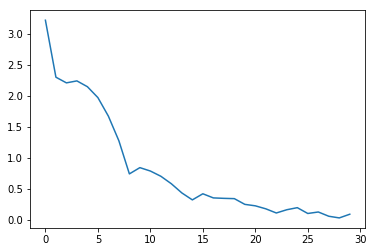

In [269]:
plt.plot(np.arange(len(loss_history)),loss_history)

Accuracy on test set is a little bit better, after 5 epochs it's already quite good. We could perform better with more epochs.

## Q8 Add a second fully connected layer. 
* A smaller number of units is recommended.

In [313]:
tf.reset_default_graph()
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
ytf = tf.placeholder(tf.int64,shape=[None, ])

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)


# Convolutional Layer #2
conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[3,3],
      padding="same",
      activation=tf.nn.relu)

# Pooling Layer #1
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

pool2_flat = tf.layers.Flatten()(pool2)

mlp = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)


mlp2 = tf.layers.dense(inputs=mlp, units=128, activation=tf.nn.relu)


logits = tf.layers.dense(inputs=mlp2, units=10)
smax = tf.nn.softmax(logits)

In [315]:
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits)

Now that we have completed the graph, we can move to the next phase: actually training the NN. Prior to entering the training loop, we need to instantiate an optimizer from `TensorFlow` and ask him to minimize the loss. We will use the ADAM optimizer which is robust and easy to tune.

In [316]:
learning_rate = 0.005
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [317]:
pred = tf.argmax(logits,1)
equal = tf.equal(pred,ytf)
accuracy = tf.reduce_mean(tf.cast(equal,tf.float32))

In [320]:
n_epochs = 20
batch_size = 150
loss_history=[]
saver = tf.train.Saver()


N_train = X.shape[0]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = N_train // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            y_batch = y[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            
            #Update parameters by computing gradient of loss
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
            loss_history.append(loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch}))
        
        #Compute loss
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        print("\n Accuracy test:", sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test}))
        print("\r{}".format(epoch), "Train loss:", loss_train)

    saver.save(sess, '/home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model_conv2_fc2')

    


83%
 Accuracy test: 0.1032
0 Train loss: 2.3043964
83%
 Accuracy test: 0.1359
1 Train loss: 2.2758348
83%
 Accuracy test: 0.4473
2 Train loss: 1.7207127
83%
 Accuracy test: 0.5857
3 Train loss: 1.2063986
83%
 Accuracy test: 0.7281
4 Train loss: 0.7561596
83%
 Accuracy test: 0.7476
5 Train loss: 0.6282973
83%
 Accuracy test: 0.7885
6 Train loss: 0.44260925
83%
 Accuracy test: 0.8336
7 Train loss: 0.34790123
83%
 Accuracy test: 0.7789
8 Train loss: 0.37136525
83%
 Accuracy test: 0.8019
9 Train loss: 0.3267982
83%
 Accuracy test: 0.8637
10 Train loss: 0.18886702
83%
 Accuracy test: 0.868
11 Train loss: 0.15907893
83%
 Accuracy test: 0.8649
12 Train loss: 0.1197848
83%
 Accuracy test: 0.8675
13 Train loss: 0.112280235
83%
 Accuracy test: 0.8682
14 Train loss: 0.088079505
83%
 Accuracy test: 0.8821
15 Train loss: 0.053903308
83%
 Accuracy test: 0.8801
16 Train loss: 0.03363791
83%
 Accuracy test: 0.8901
17 Train loss: 0.027965141
83%
 Accuracy test: 0.8792
18 Train loss: 0.03516613
83%
 Acc

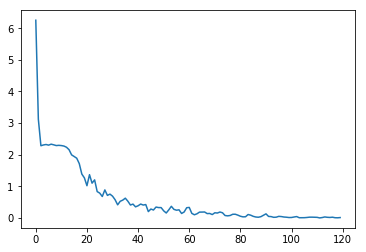

In [322]:
plt.plot(np.arange(len(loss_history)),loss_history)
plt.title("Loss")

It doesn't perform better than with less layers. This is probably because there are too many parameters to train

## Q9 try to tweak the other hyperparameters. 
 These latter include:
* the learning rate,
* the mini batch size,
* the regularization strength (if regularization is activated),
* number of filters,
* filter sizes,
* activiation functions,
* strides,
* padding types,
* ...


In this section, we are going to keep the last architecture

In [17]:
from TP6_model import *

In [37]:
## Placeholders
tf.reset_default_graph()
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
ytf = tf.placeholder(tf.int64,shape=[None, ])


## Parameters
dict_param = {'filters1':16, 'kernel_size1':5, 'padding1':"same",
              'filters2':16, 'kernel_size2':5, 'padding2':"same",
              'mlp_units1':256,
              'mlp_units2':128
              }

learning_rate = 0.001
n_epochs = 5
batch_size = 150


In [38]:
## Create Model
model = Model3(Xtf = Xtf, ytf = ytf,learning_rate = learning_rate, param_layers=dict_param)



In [39]:

## Training
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [40]:
loss_history=[]

#saver = tf.train.Saver()
for epoch in range(n_epochs):
    n_batches = N_train // batch_size

    for iteration in range(n_batches):
        print("\r{}%".format(100 * iteration // n_batches), end="")
        sys.stdout.flush()
        X_batch = X[iteration*batch_size :(iteration+1)*batch_size  ] 
        y_batch = y[iteration*batch_size :(iteration+1)*batch_size  ] 
        
        sess.run(model.optimize, feed_dict={Xtf: X_batch,ytf: y_batch})
        loss_history.append(sess.run(model.loss, feed_dict={Xtf: X_batch,ytf: y_batch}))

        #Compute loss
    loss_train = sess.run(model.loss,feed_dict={Xtf: X_batch,ytf: y_batch})
    print("\n Accuracy test:", sess.run(model.accuracy,feed_dict={Xtf: X_test,ytf: y_test}))
    print("\r{}".format(epoch), "Train loss:", loss_train)

99%
 Accuracy test: 0.9704
0 Train loss: 0.136966
99%
 Accuracy test: 0.98
1 Train loss: 0.11925721
99%
 Accuracy test: 0.9839
2 Train loss: 0.10973862
99%
 Accuracy test: 0.9838
3 Train loss: 0.11808056
99%
 Accuracy test: 0.9843
4 Train loss: 0.11189571


Text(0.5,1,'Loss')

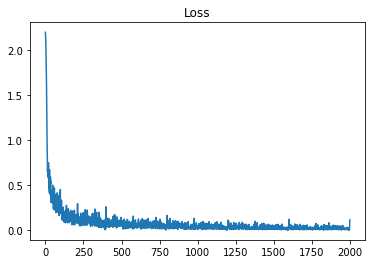

In [41]:
plt.plot(np.arange(len(loss_history)),loss_history)
plt.title("Loss")

## Q10
* Compare the obtained accuracy to that of a regularized Softmax regression from `sklearn`.

In [28]:
from sklearn.linear_model import LogisticRegression
N_train = X.shape[0]
N_test = X_test.shape[0]
clf = LogisticRegression( solver='lbfgs',multi_class='multinomial').fit(X.reshape(N_train,-1), y)


/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [29]:
print("Train set score:",clf.score(X.reshape(N_train,-1), y))
print("Test set score:" ,clf.score(X_test.reshape(N_test,-1), y_test))

Train set score: 0.935
Test set score: 0.9261


Softmax regression already gives quite good results, but a well tuned neural network performs far better.